<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_NVDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-u1gg8kd7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-u1gg8kd7
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.087622f0d4888b557639c605c04a0e822874df5ba_-cp36-none-any.whl size=123835 sha256=6bd4575d9ab5558f18a03de08bb32ffe50026b9f6c5c612e189fbdd90ce56612
  Stored in directory: /tmp/pip-ephem-wheel-cache-boryl4mq/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [58]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/NVDA/df_NVDA_20drtn_features.csv')

In [7]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,40.660631,38.532123,47.682059,42.211817,-70.344783,-72.258031,-76.630420,-64.660174,36.127340,43.167164,49.319174,40.737450,-1.633663,-0.699647,-3.025861,-2.118219,-0.251000,-0.142818,-0.281087,-0.403385,-0.343021,-0.367354,-0.367354,-0.367354,-0.367354,-32.863803,-49.411299,-72.498738,-81.790682,-40.574256,-62.103972,0.102567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298544,-0.026988,0.277627,-0.078746,0.503892,-0.050750,27.549999,2.949999,4.019999,-6.767833e+06,-6.767833e+06,-6.767833e+06,-6.767833e+06,0.124196,-0.067327,0.050321,-0.040717,0.053382,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,46.573844,37.420182,51.393327,44.236725,-56.551748,-59.354873,-65.760918,-60.776702,48.321503,49.237124,54.296974,40.598457,1.006537,0.349998,0.500753,1.261352,0.099753,-0.143791,-0.268838,-0.389764,-0.344204,-0.350031,-0.350031,-0.350031,-0.350031,41.542859,-25.948181,-37.573545,-59.825841,-33.675455,-53.184008,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277249,-0.023644,0.279008,-0.079723,0.501047,-0.044776,27.490000,-0.059999,0.949999,4.024298e+05,4.024298e+05,4.024298e+05,4.024298e+05,0.198279,-0.007957,0.036069,-0.052654,0.124612,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,55.908911,45.530486,50.640208,42.899689,-53.103390,-56.128991,-63.043465,-59.805806,57.981624,55.310678,54.685329,42.649824,0.249134,-0.396039,0.549728,0.902710,-0.740008,-0.140474,-0.256326,-0.376074,-0.345033,-0.328481,-0.328481,-0.328481,-0.328481,105.285649,0.555589,2.600553,-29.042400,-27.071237,-44.018352,0.283021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276145,-0.013426,0.276274,-0.059590,0.500913,-0.042373,29.379999,1.889999,3.099998,1.384759e+06,1.384759e+06,1.384759e+06,1.384759e+06,0.075067,0.002707,-0.008093,-0.068587,-0.091276,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,68.852448,62.777601,57.491014,46.619104,-1.123515,-1.123515,-4.347822,-38.834940,57.926355,55.866604,55.462219,44.846175,5.367793,6.693507,6.000004,2.464960,2.514509,-0.102405,-0.233546,-0.358031,-0.344999,-0.221700,-0.221700,-0.221700,-0.221700,166.666667,174.400623,183.937345,156.427093,-21.192620,-35.203272,0.974028,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.340100,0.050959,0.329509,0.003936,0.516776,0.010349,26.360001,-3.019999,0.840000,2.906066e+07,2.906066e+07,2.906066e+07,2.906066e+07,0.101039,0.099324,0.019964,-0.043356,0.166793,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,57.313777,60.542935,53.512051,47.694459,-18.048735,-18.048735,-18.048735,-40.388336,56.376682,55.241646,55.350611,44.236520,-0.377358,5.231695,4.554456,1.685125,1.052637,-0.050241,-0.205076,-0.337179,-0.344218,-0.141895,-0.141895,-0.141895,-0.141895,100.055721,169.801772,183.266059,181.742481,-17.498057,-29.007170,0.274512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341488,0.053335,0.328144,0.054617,0.500548,-0.005994,27.219999,0.859999,2.619999,1.795952e+07,1.795952e+07,1.795952e+07,1.795952e+07,0.001913,0.065260,-0.017603,-0.066345,-0.321456,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [59]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [60]:
from_date='2010-01-01'
to_date='2020-01-01'

In [61]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [62]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,82.450318,83.496652,78.336147,74.721211,-9.708685,-5.405376,-5.181319,-3.110402,77.687396,79.091669,74.428493,71.925466,1.460251,0.482058,5.393264,11.533892,31.556802,1.298234,1.107869,0.810566,0.229658,1.191452,1.191452,1.191452,1.191452,70.621404,104.607270,93.738872,101.931013,340.913058,351.435333,0.629631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287937,-0.161828,0.602378,0.008859,0.504212,-0.016778,19.350000,-0.690001,-0.580000,2.345622e+06,2.345622e+06,2.345622e+06,2.345622e+06,0.281492,0.234412,0.163433,0.114550,-0.089422,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,83.297631,87.243256,77.516899,74.396954,-5.128202,-2.325580,-2.110816,-1.244167,78.679774,79.770209,70.928473,71.283714,0.639653,1.070658,4.772468,8.381166,17.339956,1.257472,1.113860,0.837587,0.248288,1.185005,1.185005,1.185005,1.185005,71.472474,96.669812,96.708995,99.460681,335.343398,348.734908,0.885712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.253491,-0.189545,0.426482,-0.167104,0.478870,-0.021575,19.160000,-0.190001,-0.850000,2.212910e+06,2.212910e+06,2.212910e+06,2.212910e+06,0.300519,0.246697,0.130740,0.136672,-0.109079,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,68.015279,78.907972,67.246469,70.478235,-33.582048,-15.845040,-11.873324,-6.998428,68.111852,74.608877,73.000341,68.742299,-1.959740,0.108169,-0.856989,3.523496,20.901370,1.196131,1.108132,0.857605,0.266437,1.136934,1.136934,1.136934,1.136934,-37.429239,45.487724,73.155669,85.469949,328.889818,343.921856,0.285713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.265843,-0.179832,0.385812,-0.211634,0.483063,-0.021367,19.059999,-0.100000,-0.900000,-2.137470e+05,-2.137470e+05,-2.137470e+05,-2.137470e+05,0.208224,0.235996,0.179797,0.134974,-0.156163,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,63.739255,79.847242,76.137134,69.931938,-30.597044,-17.226890,-10.817941,-6.376359,59.959276,66.305895,68.775271,68.990020,0.216094,-1.119408,-0.695937,2.316603,18.228169,1.123232,1.092998,0.871265,0.284021,1.089506,1.089506,1.089506,1.089506,-55.555783,19.023935,55.753790,76.495780,316.302572,333.214516,0.697672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.259455,-0.024247,0.382488,-0.216037,0.475893,-0.027568,18.129999,-0.930000,-3.550001,1.688739e+04,1.688739e+04,1.688739e+04,1.688739e+04,0.183990,0.172244,0.170327,0.155412,-0.127099,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,52.633971,67.550675,71.221304,70.278079,-49.999929,-28.632422,-17.678057,-10.419879,53.652084,58.365979,67.628511,66.359104,-1.401608,-3.124991,-1.081660,1.105587,18.689170,1.034396,1.066713,0.877463,0.300718,1.019191,1.019191,1.019191,1.019191,-117.902534,-25.334010,28.432079,64.580446,303.843862,321.225979,0.371430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.271820,-0.021038,0.379194,-0.226072,0.476746,-0.028467,17.549999,-0.580000,-2.490002,-1.194727e+06,-1.194727e+06,-1.194727e+06,-1.194727e+06,0.153799,0.216701,0.183954,0.162171,0.164051,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [63]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,99.743785,74.279463,73.087587,68.821114,-3.458813,-2.548736,-2.548736,-2.395501,100.000000,81.243430,77.488001,67.316674,1.660574,4.853477,6.866373,12.819907,13.888098,0.468177,0.345304,0.339866,0.323564,7.236075,7.236075,7.236075,7.236075,123.741277,140.354441,146.710730,204.592750,76.684175,85.492961,0.663365,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.166621,-0.111609,0.282987,-0.051503,0.287177,-0.006513,12.51,0.010000,-0.120000,4.155021e+07,4.155021e+07,4.155021e+07,4.155021e+07,0.140521,0.088469,0.064414,0.124985,0.354060,0.389,0.014,0.093,0.290001,0.540001,1.0
2891,2019-12-23,97.529238,75.688927,73.502189,67.988018,-9.787201,-7.215227,-7.215227,-6.795432,100.000000,88.246150,78.057231,67.306829,-0.229765,4.056474,6.071514,12.560687,13.243875,0.530823,0.376296,0.354195,0.326611,7.768398,7.768398,7.768398,7.768398,88.392577,120.868658,127.547056,181.882716,84.538754,92.502788,0.125733,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.171649,-0.009074,0.284576,-0.030329,0.274035,-0.013481,12.61,0.099999,0.469999,2.607282e+07,2.607282e+07,2.607282e+07,2.607282e+07,0.079237,0.098941,0.036007,0.084774,-0.411220,0.415,0.026,0.048,-0.029999,0.610001,1.0
2892,2019-12-27,86.937234,88.672897,70.228474,65.996738,-24.712380,-15.981889,-11.920855,-11.227278,88.268055,91.389983,75.708906,66.829053,-0.969943,-0.816520,0.598823,5.712495,8.536469,0.629600,0.453287,0.396826,0.337215,8.155177,8.155177,8.155177,8.155177,-113.380702,51.640720,77.392145,111.335651,101.816975,109.426402,0.233995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166309,-0.000185,0.226861,-0.056330,0.269706,-0.016133,13.43,0.780001,0.850000,3.278317e+06,3.278317e+06,3.278317e+06,3.278317e+06,-0.101646,0.030287,0.014884,0.087818,0.392624,0.356,-0.014,-0.019,-0.669998,-0.490005,1.0
2893,2019-12-30,66.030367,79.582758,63.247198,63.219373,-55.692453,-30.702003,-22.900554,-21.957404,79.652279,85.995033,74.134770,66.419647,-1.920880,-2.640176,-2.945226,3.718917,7.188337,0.614508,0.463854,0.405784,0.340453,7.602068,7.602068,7.602068,7.602068,-166.666667,-20.408152,35.557385,72.753262,103.360071,110.955948,0.245138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207181,0.040561,0.238762,-0.044225,0.273835,-0.013342,14.82,1.389999,2.320000,-7.599053e+06,-7.599053e+06,-7.599053e+06,-7.599053e+06,-0.093097,0.008162,-0.002047,0.074214,0.013399,0.405,0.049,0.016,-0.180000,-0.680000,1.0
2894,2019-12-31,71.652962,80.125376,67.447752,65.418029,-39.963150,-21.309309,-15.709445,-15.709445,79.140236,86.108463,79.327807,66.383004,1.282712,-1.626322,-1.473915,4.508110,12.449225,0.589308,0.468972,0.412419,0.343484,7.319807,7.319807,7.319807,7.319807,-76.129134,-29.896906,32.240456,69.917058,108.129877,115.302400,0.931533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212172,0.040523,0.193276,-0.091300,0.274602,0.000567,13.78,-1.040000,1.270000,6.705560e+05,6.705560e+05,6.705560e+05,6.705560e+05,0.046622,0.061453,0.081697,0.078542,-0.104830,0.414,0.009,-0.001,-0.349998,-1.320000,1.0


In [64]:
df.drop(['timestamp'], inplace=True, axis=1)

In [65]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [66]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,71.732900,74.624996,69.835323,62.899520,-9.597508,-9.597508,-8.310979,-5.410113,71.361115,72.637996,73.932788,56.233435,2.500003,3.123734,9.098716,8.032296,16.873564,0.427348,0.315135,0.268429,0.111931,0.674309,0.674309,0.674309,0.674309,151.008758,165.829872,217.893262,227.988956,76.620417,84.550491,0.655556,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.346331,0.132142,0.293278,-0.020277,0.388267,-0.087947,19.540001,-1.400000,-8.089998,4.505644e+06,4.505644e+06,4.505644e+06,4.505644e+06,0.330113,0.309816,0.269706,0.104451,0.248301,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,20.785247,25.931002,25.154227,39.870336,-83.674248,-87.368118,-89.752739,-89.911055,34.532052,39.734526,40.836776,55.344309,2.181218,-3.202450,-4.307576,-10.426898,-18.676247,-0.803999,-0.373000,-0.086713,0.135920,-6.998429,-6.998429,-6.998429,-6.998429,-58.757548,-92.888401,-97.439425,-129.074026,-112.654336,-104.084614,0.790850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.405551,0.008725,0.360521,0.004920,0.315382,-0.042191,14.950000,-1.360000,-3.110000,-2.463543e+07,-2.463543e+07,-2.463543e+07,-2.463543e+07,-0.053182,-0.028903,0.043218,0.043336,-0.367469,0.096,2.384186e-07,0.030,0.129997,0.529999,0.0
898,51.782159,62.545188,62.311634,56.746222,-8.808293,-14.146338,-6.561085,-10.799136,56.543820,72.576346,75.213455,59.223602,2.295084,7.958482,7.734813,-0.763358,24.700241,0.375212,0.297403,0.201129,-0.139410,0.321060,0.321060,0.321060,0.321060,118.518559,106.119801,103.746521,99.402641,88.169596,95.906549,0.787880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.580998,-0.007880,0.629364,-0.007766,0.589148,0.007707,24.530001,-0.929998,-6.789999,2.960603e+06,2.960603e+06,2.960603e+06,2.960603e+06,0.009903,0.054711,0.176770,0.001250,-0.151586,2.296,-8.899999e-02,0.108,0.219994,-1.210007,0.0
765,62.421215,45.231437,56.320570,37.560848,-17.924572,-17.924572,-38.078288,-73.952100,57.479983,38.315935,42.126512,34.346359,3.052160,-0.748260,4.560808,6.357392,4.267267,-0.164387,-0.418731,-0.456723,0.081684,-0.318711,-0.318711,-0.318711,-0.318711,77.557782,124.732443,126.612386,67.975319,-71.218202,-95.789171,0.441175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425718,0.076872,0.494852,0.034843,0.456632,-0.111830,15.070000,-0.760000,-1.850000,3.278521e+06,3.278521e+06,3.278521e+06,3.278521e+06,0.325536,0.078563,0.030065,-0.133578,-0.014161,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,0.0
1100,42.236407,60.243839,61.205954,56.066076,-84.126926,-75.652126,-41.037733,-28.431365,28.718800,56.908788,57.659338,52.515896,-1.712329,-1.980874,-2.047776,-3.106010,7.651916,0.412271,0.420153,0.339942,0.045281,0.322913,0.322913,0.322913,0.322913,-63.491999,-112.597431,-54.948708,42.674757,110.573956,110.499140,0.034484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.231528,-0.008082,0.243214,0.011894,0.302874,-0.026072,16.350000,1.170000,2.330000,-5.940714e+05,-5.940714e+05,-5.940714e+05,-5.940714e+05,-0.094102,-0.005187,0.018741,0.001428,-0.019498,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,0.0


In [67]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [68]:
train_labels.head()

1856    1.0
2747    0.0
898     0.0
765     0.0
1100    0.0
Name: labels, dtype: float64

In [69]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [70]:
get_sample_weights(train_labels)

real class weights are [1.21890547 0.84775087] [0 1]
value_counts (array([0, 1]), array([ 804, 1156]))


1856    0.847751
2747    1.218905
898     1.218905
765     1.218905
1100    1.218905
          ...   
2051    0.847751
1301    0.847751
2192    1.218905
1640    1.218905
2882    0.847751
Name: labels, Length: 1960, dtype: float64

In [71]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.21890547 0.84775087] [0 1]
value_counts (array([0, 1]), array([ 804, 1156]))


In [72]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [73]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [74]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_20',
 'rsi_40',
 'mfi_40',
 'roc_10',
 'roc_20',
 'trix_10',
 'trix_15',
 'trix_20',
 'macd20',
 'macd40',
 'kst_20',
 'bb_l20',
 'bb_l40',
 'realised_vol_10',
 'cmf_10',
 'cmf_15',
 'cmf_20',
 'cmf_40',
 'curve',
 'dollarix_5d_change')

In [75]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_40',
 'wr_40',
 'mfi_20',
 'mfi_40',
 'trix_10',
 'trix_15',
 'trix_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'kst_40',
 'realised_vol_20',
 'realised_vol_40',
 'realised_vol_change_5d_40',
 'vix_level',
 'cmf_10',
 'cmf_20',
 'curve')

In [76]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_40,wr_40,mfi_20,mfi_40,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,kst_40,realised_vol_20,realised_vol_40,realised_vol_change_5d_40,vix_level,cmf_10,cmf_20,curve
445,1.938907,1.238991,1.563041,1.884008,2.365323,2.355317,1.875262,0.452054,0.183971,0.183971,0.183971,0.183971,2.722742,1.432272,0.886651,-0.316168,0.445087,1.189699,0.855809,2.013397
448,1.494065,1.132045,1.135960,1.579943,2.017774,2.320368,2.036908,0.651767,0.151825,0.151825,0.151825,0.151825,2.565923,0.088893,0.688599,-0.533177,0.226020,0.713818,0.902231,2.093196
452,1.057444,0.663522,0.379076,0.786788,1.125367,1.905104,1.968262,0.866849,0.036827,0.036827,0.036827,0.036827,2.145587,0.201655,0.793530,0.178849,0.136238,0.471160,1.310589,2.006838
469,-0.239783,-1.151612,-1.523242,-0.379362,-1.053226,-0.536468,0.118832,0.859022,-0.265267,-0.265267,-0.265267,-0.265267,-0.621380,0.782930,0.521207,-2.013803,1.639183,0.312706,-0.388967,1.836308
470,-0.047851,-0.885176,-1.217380,-0.210464,-1.018871,-0.587711,0.038598,0.829975,-0.260970,-0.260970,-0.260970,-0.260970,-0.701893,0.760174,0.525511,-1.922896,1.531445,0.004934,-0.282903,1.902990


In [77]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [78]:
tf.random.set_seed(1)

criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [79]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.49056977, 0.5094302 ],
       [0.5583103 , 0.44168973],
       [0.53675884, 0.46324116],
       [0.53729606, 0.4627039 ],
       [0.5227979 , 0.4772021 ],
       [0.5500346 , 0.44996548],
       [0.58800405, 0.41199595],
       [0.4743766 , 0.52562344],
       [0.4679969 , 0.5320031 ],
       [0.55972433, 0.44027564]], dtype=float32)

In [80]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
79/79 [==============================] - ETA: 0s - loss: 0.7276 - accuracy: 0.4917
Epoch: 0, accuracy:0.4917,  loss:0.7276,  val_accuracy:0.5663,  val_loss:0.6772,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7276 - accuracy: 0.4917 - val_loss: 0.6772 - val_accuracy: 0.5663
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6961 - accuracy: 0.5261 - val_loss: 0.6671 - val_accuracy: 0.6199
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.5497 - val_loss: 0.6600 - val_accuracy: 0.6071
Epoch 4/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5676 - val_loss: 0.6496 - val_accuracy: 0.5893
Epoch 5/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6778 - accuracy: 0.5599 - val_loss: 0.6462 - val_accuracy: 0.6429
Epoch 6/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6677 - accuracy: 0.5855 - val_loss: 0.6374 - val_accur

In [81]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.305210,0.874362,0.349593,0.852041,195
196,0.313224,0.860969,0.363987,0.867347,196
197,0.317411,0.855230,0.359643,0.854592,197
198,0.315585,0.862245,0.360584,0.862245,198
199,0.294182,0.872449,0.371769,0.849490,199


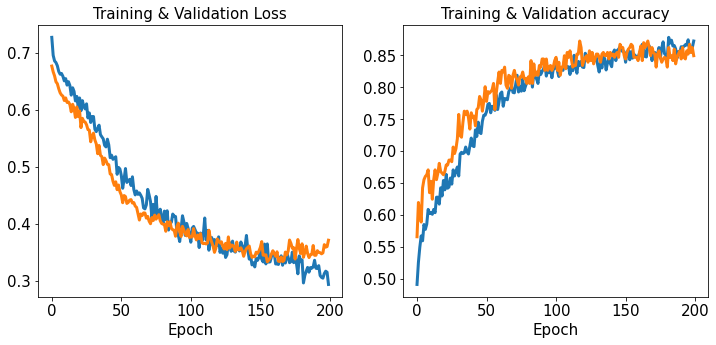

In [82]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [32]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394130 sha256=fa7a3695c4152743202e7de8bd95b7d76cec14ad3ea03f3ef255b7369251cec7
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [83]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [84]:
shap_values  = explainer.shap_values(np.array(X_test_new))

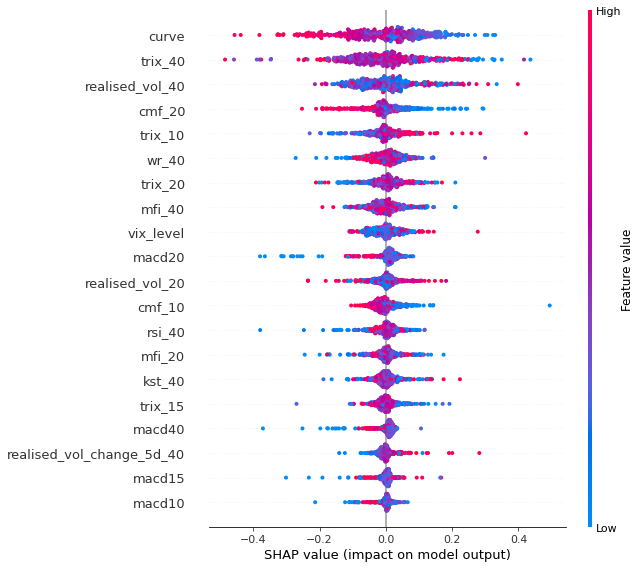

In [85]:
shap.summary_plot(shap_values[1], X_test_new)

In [86]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [87]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


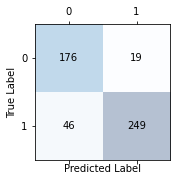

In [88]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [89]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.929
Recall: 0.844
F1: 0.885


In [90]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [91]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [93]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [20,30,40],
  }
]

In [94]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [95]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [96]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [47]:
model = grid.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed: 25.1min finished


In [49]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/INTC/xgb_INTC_log_reg.pickle', "wb"))

In [50]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

ValueError: ignored

Confusion Matrix


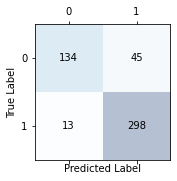

In [101]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [102]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.1, 'clf__learning_rate': 0.1, 'clf__max_depth': 9, 'clf__n_estimators': 200, 'fs__k': 40, 'fs__score_func': <function mutual_info_classif at 0x7fedf81f00d0>}


In [97]:
model_opt = xgb.XGBClassifier(max_depth=9,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.1)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model_opt.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.216327	validation_0-logloss:0.657227	validation_1-error:0.293878	validation_1-logloss:0.671024
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.158673	validation_0-logloss:0.629778	validation_1-error:0.316327	validation_1-logloss:0.657517
[2]	validation_0-error:0.081122	validation_0-logloss:0.586872	validation_1-error:0.226531	validation_1-logloss:0.624386
[3]	validation_0-error:0.069898	validation_0-logloss:0.548404	validation_1-error:0.195918	validation_1-logloss:0.599917
[4]	validation_0-error:0.060714	validation_0-logloss:0.531115	validation_1-error:0.189796	validation_1-logloss:0.590319
[5]	validation_0-error:0.05051	validation_0-logloss:0.501164	validation_1-error:0.171429	validation_1-logloss:0.570275
[6]	validation_0-error:0.043367	validation_0-logloss:0.474632	validation_1-error:0.171429	validation_1-logloss:0.549

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [98]:

# make predictions for test data
y_pred = model_opt.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.57%


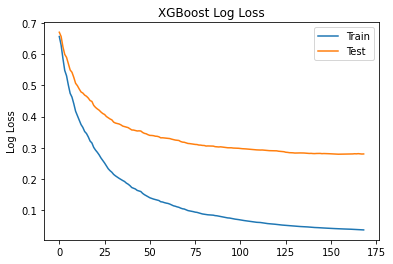

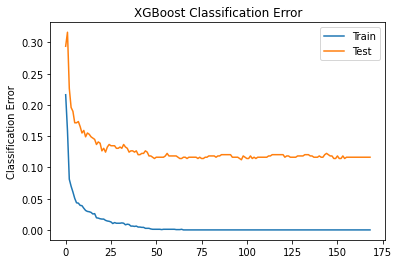

In [99]:
from matplotlib import pyplot

results = model_opt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [100]:
shap_values = shap.TreeExplainer(model_opt).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


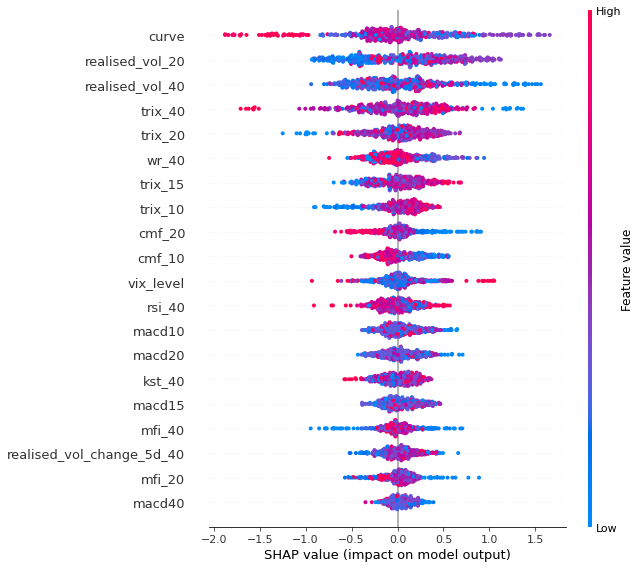

In [101]:
shap.summary_plot(shap_values, X_test_new)

In [102]:
predict = model_opt.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


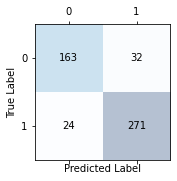

In [103]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()